# Customer segmentation

In [1]:
import gc
import csv
import os
import pickle
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from dateutil.relativedelta import *
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
invoices = pd.read_csv("invoices_2009_2011_no_returns.csv")
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

In [3]:
# Cohort are customers who made their first purchase in the first year
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]

In [4]:
def get_money_aggregation_features(cohort_invoices):
    cohort_invoices = cohort_invoices.copy()
    daily_customer_revenues = cohort_invoices.groupby(["CustomerID", cohort_invoices["InvoiceDate"].dt.to_period("D")])['Revenue'].sum().reset_index()
    aggregation_features = daily_customer_revenues.groupby('CustomerID')['Revenue'].agg([
        'mean',
        'std',
        'min',
        'max', 
        'sum',
        'size',
    ]).reset_index()

    # Rename features
    aggregation_features.columns = [
        'CustomerID',
        'MeanPurchaseValue',
        'StDevPurchaseValue',
        'MinPurchaseValue',
        'MaxPurchaseValue',
        'SumPurchaseValue',
        'SizePurchaseValue',
    ]
    # Customers who purchased more than once in the first year
    aggregation_features.dropna(inplace=True)   
    
    return aggregation_features


def log_transform_features(features, feats_to_transform): 
    features = features.copy()
    for feat in feats_to_transform:
        features[feat] = np.log1p(features[feat])
        features.rename(columns={feat:f'log(1+{feat})'}, inplace=True)
    
    return features


def get_rfm_features(features, cohort_invoices):
    cohort_invoices = cohort_invoices.copy()
    features = features.copy()

    rfm_features = summary_data_from_transaction_data(
        transactions=cohort_invoices,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        monetary_value_col='Revenue',
        freq='D'
    ).reset_index()
    features = features.merge(rfm_features, how='left', on='CustomerID')
    features['T_Minus_Recency'] = rfm_features['T'] - rfm_features['recency']
    
    return features


def get_total_first_year_revenue(features, cohort_invoices):
    cohort_invoices = cohort_invoices.copy()
    features = features.copy()
    
    features = features.merge(
        cohort_invoices.groupby('CustomerID')['Revenue'].sum().reset_index(),
        how='left',
        on='CustomerID'
    )
    features.rename(columns={'Revenue':'TotalFirstYearRevenue'}, inplace=True)
    features['log(1+TotalFirstYearRevenue)'] = np.log1p(features['TotalFirstYearRevenue'])
    
    return features


def get_second_year_rlv(features, cohort_invoices):
    cohort_invoices = cohort_invoices.copy()
    features = features.copy()
    
    second_year_cohort_revenues = cohort_invoices.groupby('CustomerID')['Revenue'].sum().reset_index()
    second_year_cohort_revenues.columns = ['CustomerID', 'SecondYearRLV']
    features = features.merge(second_year_cohort_revenues, how='left', on='CustomerID')
    features.fillna(value=0, inplace=True)
    
    return features


def cluster_elbow_method(features, cluster_feats):
    sse = []
    mm_scaler = MinMaxScaler()
    
    for k in range(1,10):
        kmeans = KMeans(n_clusters=k, n_init=200, max_iter=1000).fit(mm_scaler.fit_transform(features[cluster_feats]))
        sse.append(kmeans.inertia_)
    
    plt.plot(list(range(1,10)), sse)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Intertia")
    
    
def perform_clustering(features, cluster_feats, num_clusters):
    features = features.copy()
    mm_scaler = MinMaxScaler()
    scaled_monetary_feats = mm_scaler.fit_transform(features[cluster_feats])
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, n_init=200, n_jobs=4)
    kmeans.fit(scaled_monetary_feats)
    features['Cluster'] = kmeans.labels_
    features['Cluster'] = features['Cluster'].astype(int)
    print(f"Inertia for {num_clusters} clusters: {kmeans.inertia_}")
    
    return features, mm_scaler, kmeans.cluster_centers_


def reorder_clusters(features, cluster_centers, num_clusters):
    features = features.copy()
    ordered_cluster_centres = np.zeros_like(cluster_centers)
    
    rlv_centres = []
    for cluster_num in range(num_clusters):
        rlv_centres.append(features[features['Cluster']==cluster_num].SecondYearRLV.mean())
    cluster_idx_rlv_pairs = list(zip([cluster_num for cluster_num in range(num_clusters)], rlv_centres))
    
    # Order list of (Cluster, RLV) tuple pairs from smallest to largest RLV
    sorted_idx_rlv_pairs = sorted(cluster_idx_rlv_pairs, key = lambda x: x[1])  
    cluster_reorder_mapping = {enum[1][0] : enum[0] for enum in enumerate(sorted_idx_rlv_pairs)}
    features['Cluster'].replace(cluster_reorder_mapping, inplace=True)
    
    sorted_cluster_centers = np.zeros_like(cluster_centers)
    for old_cluster_idx, new_cluster_idx in cluster_reorder_mapping.items():
        sorted_cluster_centers[new_cluster_idx] = cluster_centers[old_cluster_idx]
    
    return features, sorted_cluster_centers


def evaluate_clusters(features, num_clusters):
    labeled_rlv_centres = []
    rlv_centres = []
    for cluster_num in range(num_clusters):
        labeled_rlv_centres.append((cluster_num, features[features['Cluster']==cluster_num].SecondYearRLV.mean()))
        rlv_centres.append(features[features['Cluster']==cluster_num].SecondYearRLV.mean())
    diff = [abs(j-i) for i,j in zip(rlv_centres, rlv_centres[1:])]
    
    print(f"Cluster labels - 0 = Low value customer, {num_clusters} = High value customer")
    print(f"Average 2nd year RLV: {labeled_rlv_centres}")
    print(f"Differences: {diff}")
    print("Value Counts:")
    print(features.Cluster.value_counts().sort_index())

    
def cluster_rf_plot(features):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    sns.scatterplot(
        'recency', 
        'frequency',
        hue='Cluster', 
        size='SecondYearRLV',
        palette='rainbow',
        sizes = (0,1000),
        alpha=0.8,
        data=features,
        ax=ax
    )
    ax.grid(alpha=0.2)
    ax.set_facecolor("snow")
    
    
def cluster_pca_plot(features, cluster_feats, mm_scaler, sorted_cluster_centers):
    pca = PCA(n_components=2)
    scaled_cluster_feats = mm_scaler.transform(features[cluster_feats])
    pca_cluster_feats = pca.fit_transform(scaled_cluster_feats)

    pca_cluster_feats_df = pd.DataFrame(np.column_stack((pca_cluster_feats, features['Cluster'].values)), columns=['PC1', 'PC2', 'Cluster'])
    pca_cluster_feats_df['Cluster'] = pca_cluster_feats_df['Cluster'].astype(int)
    pca_cluster_feats_df['SecondYearRLV'] = features['SecondYearRLV']
    pca_cluster_feats_df['CustomerID'] = features['CustomerID']
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]}")
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    sns.scatterplot(
        'PC1', 
        'PC2',
        hue='Cluster', 
        size='SecondYearRLV',
        palette='rainbow',
        sizes = (0,1000),
        data=pca_cluster_feats_df,
        ax=ax
    )
    ax.grid(alpha=0.2)
    ax.set_facecolor("snow")
    plt.scatter(
        pca.transform(sorted_cluster_centers)[:,0],
        pca.transform(sorted_cluster_centers)[:,1],
        marker='x',
        color='k',
        s=100,
    )
    
    return pca

<br>
<br>

# Cluster on RFM features

In [5]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MeanPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,84.680000,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,874.420000,601.342019,200.00,1354.74,2623.26,3,2.0,182.0,215.0,777.370,30.0,2623.26,7.872554,1757.55
2,12352.0,171.900000,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,2506.04
3,12356.0,1187.416667,1005.097218,349.85,2301.96,3562.25,3,2.0,44.0,50.0,1325.905,33.0,3562.25,8.178428,2811.43
4,12358.0,828.503333,581.945176,268.10,1429.83,2485.51,3,2.0,356.0,357.0,527.840,1.0,2485.51,7.818635,1168.06


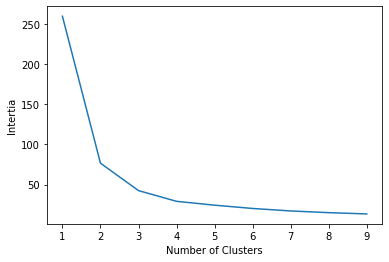

In [6]:
cluster_feats = [
    'recency',
    'frequency',
    'monetary_value'   
]

cluster_elbow_method(features, cluster_feats)

In [7]:
num_clusters = 4
features, mm_scaler, cluster_centers  = perform_clustering(features, cluster_feats, num_clusters)
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters)

Inertia for 4 clusters: 29.066614940557397
Cluster labels - 0 = Low value customer, 4 = High value customer
Average 2nd year RLV: [(0, 1288.556089193825), (1, 1298.5477104874444), (2, 1452.4555040871933), (3, 5074.484303947368)]
Differences: [9.991621293619346, 153.90779359974886, 3622.028799860175]
Value Counts:
0    583
1    677
2    734
3    760
Name: Cluster, dtype: int64


Explained variance ratio: [0.94102593 0.03426621]
Total explained variance: 0.975292142088093


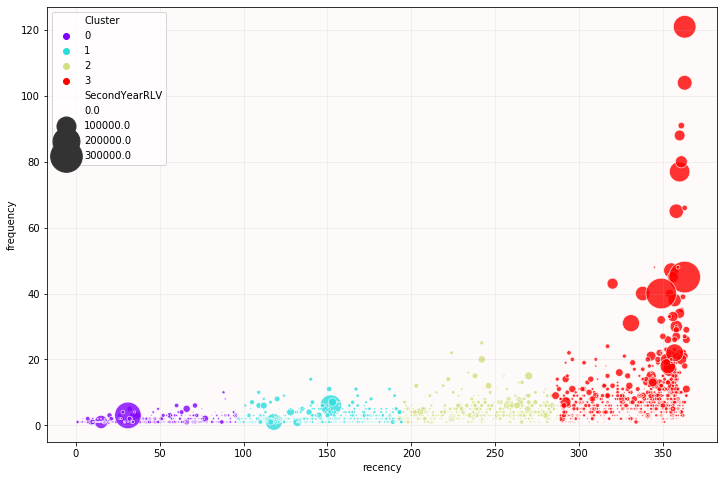

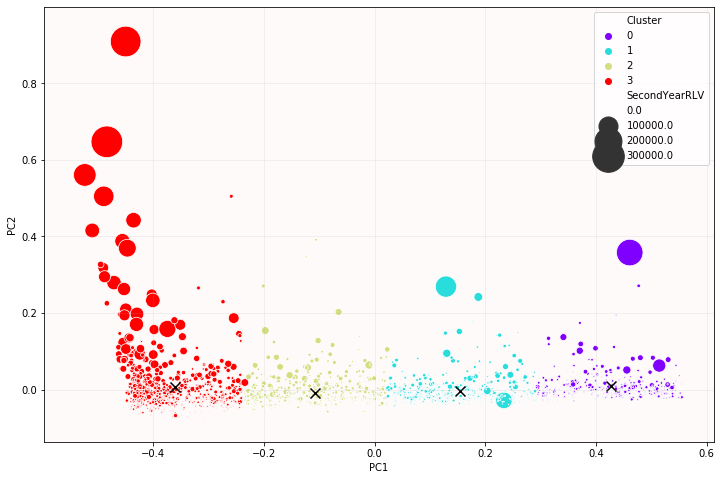

In [8]:
cluster_rf_plot(features)
pca = cluster_pca_plot(features, cluster_feats, mm_scaler, sorted_cluster_centers)

<br>
<br>

# Cluster on monetary aggregation features

In [9]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])

feats_to_transform = [
    'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue', 
]

features = log_transform_features(features, feats_to_transform)

features.head()

,CustomerID,log(1+MeanPurchaseValue),log(1+StDevPurchaseValue),log(1+MinPurchaseValue),log(1+MaxPurchaseValue),log(1+SumPurchaseValue),SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,4.450619,4.412812,3.333989,4.965010,5.137914,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,6.774704,6.400825,5.303305,7.212103,7.872554,3,2.0,182.0,215.0,777.370,30.0,2623.26,7.872554,1757.55
2,12352.0,5.152713,3.708930,4.975008,5.303554,5.842965,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,2506.04
3,12356.0,7.080377,6.913834,5.860359,7.741951,8.178428,3,2.0,44.0,50.0,1325.905,33.0,3562.25,8.178428,2811.43
4,12358.0,6.720827,6.368093,5.595083,7.266010,7.818635,3,2.0,356.0,357.0,527.840,1.0,2485.51,7.818635,1168.06


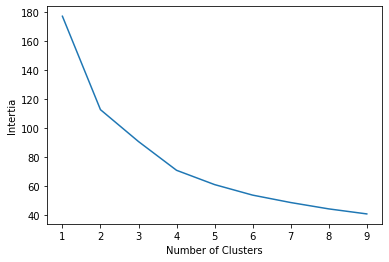

In [10]:
cluster_feats = [
    'log(1+MeanPurchaseValue)',
    'log(1+StDevPurchaseValue)',
    'log(1+MinPurchaseValue)',
    'log(1+MaxPurchaseValue)',
    'log(1+SumPurchaseValue)',
]
cluster_elbow_method(features, cluster_feats)

In [11]:
num_clusters = 4
features, mm_scaler, cluster_centers  = perform_clustering(features, cluster_feats, num_clusters)
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters)

Inertia for 4 clusters: 70.98217782005372
Cluster labels - 0 = Low value customer, 4 = High value customer
Average 2nd year RLV: [(0, 519.7004845814978), (1, 1189.9777657935285), (2, 2418.9693114754114), (3, 8333.537448936167)]
Differences: [670.2772812120307, 1228.9915456818828, 5914.568137460756]
Value Counts:
0     681
1    1298
2     305
3     470
Name: Cluster, dtype: int64


Explained variance ratio: [0.63004235 0.28024899]
Total explained variance: 0.9102913385173563


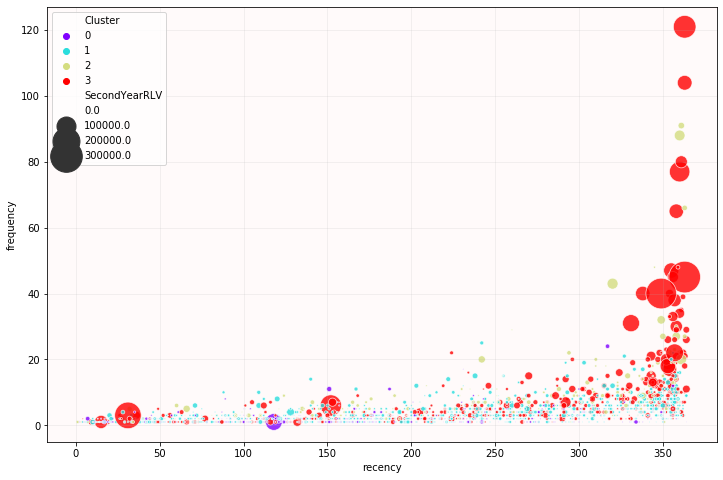

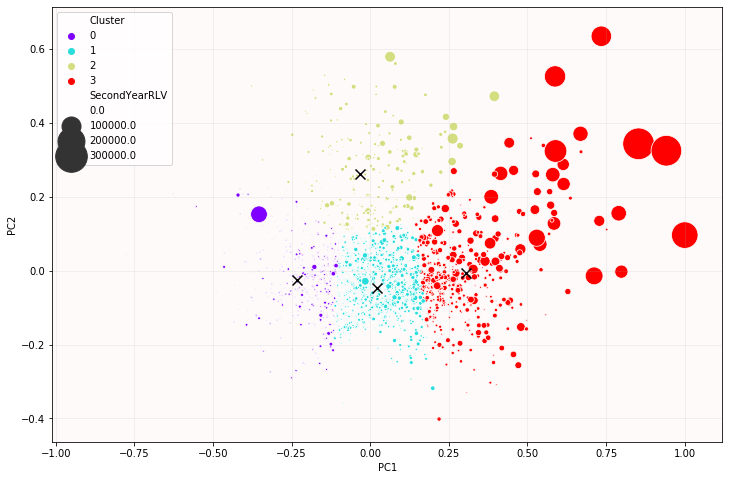

In [12]:
cluster_rf_plot(features)
pca = cluster_pca_plot(features, cluster_feats, mm_scaler, sorted_cluster_centers)

<br>
<br>

# Pareto

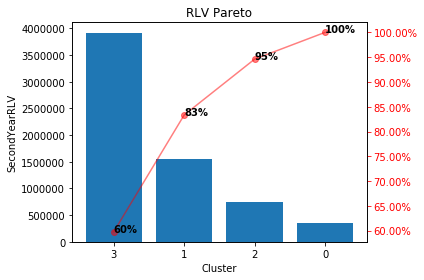

In [13]:
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots()
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

df = features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
df['Cluster'] = df['Cluster'].astype(str)
pareto_plot(df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

<br>
<br>

# Cluster statistics and distributions

In [14]:
for cluster in range(num_clusters):
    print(features[features.Cluster==cluster].mean())
    print()

CustomerID                      15561.794420
log(1+MeanPurchaseValue)            5.035661
log(1+StDevPurchaseValue)           3.589418
log(1+MinPurchaseValue)             4.640566
log(1+MaxPurchaseValue)             5.299697
log(1+SumPurchaseValue)             6.044600
SizePurchaseValue                   3.085169
frequency                           2.085169
recency                           158.080764
T                                 235.766520
monetary_value                    161.825566
T_Minus_Recency                    90.516887
TotalFirstYearRevenue             497.489941
log(1+TotalFirstYearRevenue)        6.044600
SecondYearRLV                     519.700485
Cluster                             0.000000
dtype: float64

CustomerID                      15363.034669
log(1+MeanPurchaseValue)            5.862355
log(1+StDevPurchaseValue)           4.722449
log(1+MinPurchaseValue)             5.359399
log(1+MaxPurchaseValue)             6.219098
log(1+SumPurchaseValue)             7.1

**Why log transform?**

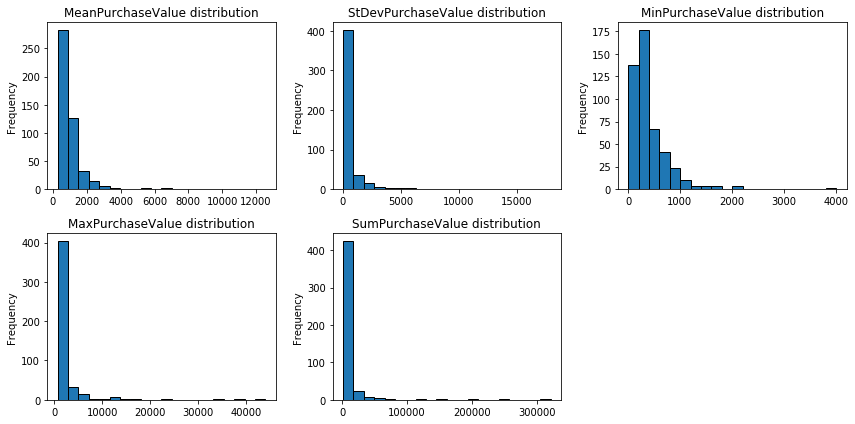

In [15]:
cluster = 3
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(cluster_feats):
    ax = fig.add_subplot(2,3,idx+1)
    (np.exp(features[features.Cluster==cluster][feat])-1).plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat[6:-1]} distribution")
plt.tight_layout()

Before log transformations all of the monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are also relatively high spenders but don't spend as much, which is undesirable. The KMeans algorithm won't group these customers together unless the right side of the axis is "squashed" together which the log(1+X) transform achieves.  

<br>
<br>

Typical Customer

In [16]:
closest, _ = pairwise_distances_argmin_min(sorted_cluster_centers, mm_scaler.transform(features[cluster_feats]))
closest

array([ 712, 1769, 1504, 2162], dtype=int64)

In [17]:
typical_customers = []
for i in closest:
    typical_customers.append(features.iloc[i].CustomerID)
    print(features.iloc[i])

CustomerID                      13948.000000
log(1+MeanPurchaseValue)            5.010102
log(1+StDevPurchaseValue)           3.697077
log(1+MinPurchaseValue)             4.678978
log(1+MaxPurchaseValue)             5.222785
log(1+SumPurchaseValue)             6.104257
SizePurchaseValue                   3.000000
frequency                           2.000000
recency                           324.000000
T                                 361.000000
monetary_value                    145.555000
T_Minus_Recency                    19.000000
TotalFirstYearRevenue             446.760000
log(1+TotalFirstYearRevenue)        6.104257
SecondYearRLV                     102.000000
Cluster                             0.000000
Name: 712, dtype: float64
CustomerID                      16167.000000
log(1+MeanPurchaseValue)            5.850851
log(1+StDevPurchaseValue)           4.833131
log(1+MinPurchaseValue)             5.243492
log(1+MaxPurchaseValue)             6.187833
log(1+SumPurchaseValue)      

In [18]:
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", cohort_invoices["InvoiceDate"].dt.to_period("D")])['Revenue'].sum().reset_index()

In [19]:
for customer in typical_customers:
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

 CustomerID InvoiceDate  Revenue
    13948.0  2009-12-04   155.65
    13948.0  2010-03-01   106.66
    13948.0  2010-10-24   184.45
    13948.0  2010-12-14   102.00

 CustomerID InvoiceDate  Revenue
    16167.0  2009-12-01   485.79
    16167.0  2010-04-01   387.45
    16167.0  2010-09-27   324.55
    16167.0  2010-10-21   188.33

 CustomerID InvoiceDate  Revenue
    15625.0  2010-06-15   508.13
    15625.0  2010-06-16    20.40
    15625.0  2010-07-01   282.74
    15625.0  2010-08-24   347.54
    15625.0  2010-11-28   409.60
    15625.0  2011-04-18   695.33
    15625.0  2011-06-13   249.94
    15625.0  2011-08-01   301.14
    15625.0  2011-08-28   287.85

 CustomerID InvoiceDate  Revenue
    16984.0  2010-03-07  1743.82
    16984.0  2010-03-24   342.36
    16984.0  2010-04-25   918.88
    16984.0  2010-06-07   870.30
    16984.0  2010-07-28   753.05
    16984.0  2010-08-18   393.41
    16984.0  2010-10-31  1178.47
    16984.0  2011-08-01  3144.68
    16984.0  2011-09-12  1255.22



<br>
<br>